In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm

In [2]:
# Download historical data for S&P 500 index
sp500 = yf.download('^GSPC', start='2010-01-01', end='2023-06-28')

[*********************100%***********************]  1 of 1 completed


In [3]:
# Check if there are any NaN values in the Close prices
print(f"NaN values in 'Close' prices: {sp500['Close'].isna().sum()}")

NaN values in 'Close' prices: 0


In [4]:
# Calculate the daily returns
sp500['return'] = sp500['Close'].pct_change()

In [5]:
# Drop NaN values
sp500 = sp500.dropna()

In [6]:
# Create a DataFrame for storing values
df = sp500.assign(
    month = sp500.index.month,
    day = sp500.index.day,
    positive = sp500['return'] > 0,
)

In [7]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,return,month,day,positive
Date,,,,,,,,,,
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000,0.003116,1,5,True
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000,0.000546,1,6,True
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000,0.004001,1,7,True
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000,0.002882,1,8,True
2010-01-11,1145.959961,1149.739990,1142.020020,1146.979980,1146.979980,4255780000,0.001747,1,11,True
2010-01-12,1143.810059,1143.810059,1131.770020,1136.219971,1136.219971,4716160000,-0.009381,1,12,False
2010-01-13,1137.310059,1148.400024,1133.180054,1145.680054,1145.680054,4170360000,0.008326,1,13,True
2010-01-14,1145.680054,1150.410034,1143.800049,1148.459961,1148.459961,3915200000,0.002426,1,14,True
2010-01-15,1147.719971,1147.770020,1131.390015,1136.030029,1136.030029,4758730000,-0.010823,1,15,False


In [8]:
# Define month number (1 = January, 2 = February, ..., 12 = December)
month_number = 7

# Define a mapping from month numbers to month names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Get the month name from the dictionary
month_name = month_names[month_number]

# Filter only for the desired month
df = df[df['month'] == month_number]

In [9]:
# Group by day and calculate the mean return and the proportion of positive return days
average_returns = df.groupby('day')['return'].mean().to_frame().T
positive_days = df.groupby('day')['positive'].mean().to_frame().T

df = df.iloc[1:].dropna(subset=['return'])

# Create weekday groups
day_groups = df.groupby('day')

# List of days that exist in the dataset, sorted
existing_days = sorted(df['day'].unique())

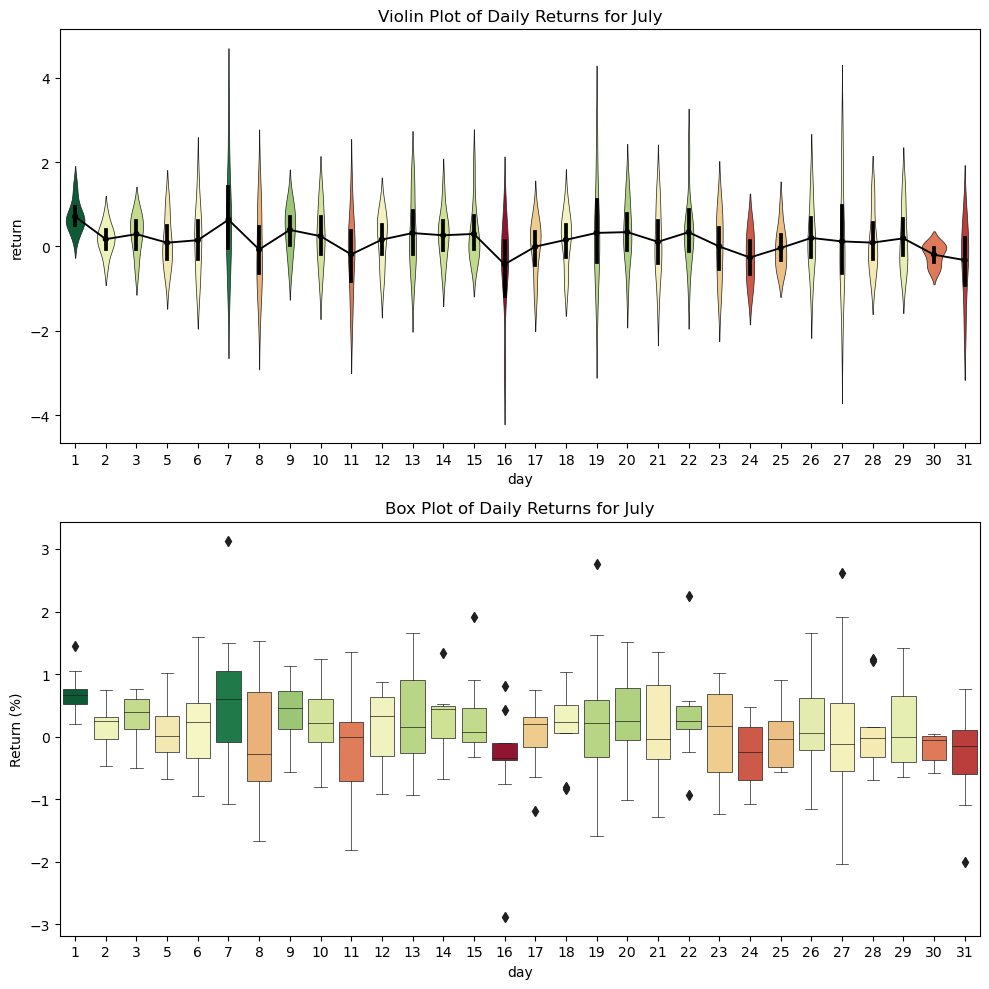

In [10]:
# Determine the colors for the violin plot and box plot based on mean return
mean_return = day_groups['return'].mean()
norm = plt.Normalize(mean_return.min(), mean_return.max())
sm = plt.cm.ScalarMappable(cmap="RdYlGn", norm=norm)
sm.set_array([])

# Create the first figure for violin and box plots
fig1, axs1 = plt.subplots(2, 1, figsize=(10, 10))

# Plot the violin plot for daily seasonality
sns.violinplot(x=df['day'], y=df['return']*100, ax=axs1[0], inner=None, palette=sm.to_rgba(mean_return.values), linewidth=0.5)
axs1[0].set_title(f'Violin Plot of Daily Returns for {month_name}')
axs1[0].set_ylabel('Return (%)')

# Add a line for the mean
sns.pointplot(x=df['day'], y=df['return']*100, ax=axs1[0], color='black', estimator=np.mean, linestyles='-', scale=0.5)

# Create a boxplot
sns.boxplot(x=df['day'], y=df['return']*100, ax=axs1[1], palette=sm.to_rgba(mean_return.values), linewidth=0.5)
axs1[1].set_title(f'Box Plot of Daily Returns for {month_name}')
axs1[1].set_ylabel('Return (%)')

plt.tight_layout()
plt.show()


In [12]:
# Create the figure for the bar plots
fig, axs = plt.subplots(2, 1, figsize=(10, 7))

# Create a colormap for average returns
cmap = plt.get_cmap("RdYlBu")
norm = plt.Normalize(average_returns.values.min(), average_returns.values.max())
colors = cmap(norm(average_returns.values))

# Create the bar plot for average returns
average_returns_percentage = average_returns * 100
average_returns_percentage.plot(kind='bar', color=colors, ax=axs[0])
axs[0].set_title(f'Average Daily Returns for {month_name}')
axs[0].set_ylabel('Return (%)')
axs[0].set_xlabel('Day of the Month')
axs[0].set_ylim([average_returns_percentage.min()*1.5, average_returns_percentage.max()*1.5])  # Add more space for annotations

# Add annotations to the bars with reduced font size
for p in axs[0].patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    # Check if the value is positive or negative and adjust the position of the annotation accordingly
    if height >= 0:
        axs[0].annotate((f'{height:.0f}' if height.is_integer() else f'{height:.2f}') + '%', (x + width/2, y + height*1.02), ha='center', fontsize=6)
    else:
        axs[0].annotate((f'{height:.0f}' if height.is_integer() else f'{height:.2f}') + '%', (x + width/2, y + height*1.05 - 0.05), ha='center', fontsize=6)

# Create a color map for the proportion of positive return days
norm_positive_days = plt.Normalize(0, 1)  # Normalize between 0 and 1
colors_positive_days = plt.cm.RdYlGn(norm_positive_days(positive_days.values))  # Get the colors

# Create the bar plot for positive return days with updated colors
positive_days_percentage = positive_days * 100
positive_days_percentage.plot(kind='bar', color=colors_positive_days, ax=axs[1])
axs[1].set_title(f'Proportion of Positive Return Days for {month_name}')
axs[1].set_ylabel('Proportion (%)')
axs[1].set_xlabel('Day of the Month')
axs[1].set_ylim([0, 100])  # Add more space for annotations

# Add annotations to the bars with reduced font size and vertical orientation
for p in axs[1].patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    axs[1].annotate((f'{height:.0f}' if height.is_integer() else f'{height:.2f}') + '%', (x + width/2, y + height*1.03), ha='center', va='bottom', fontsize=6, rotation=90)

plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (298661547.py, line 52)

In [ ]:
# Define the sectors and the start and end dates
sectors = ['XLB', 'XLY', 'XLF', 'XLP', 'XLV', 'XLU', 'XLE', 'XLI', 'XLK']
start_date = '2002-01-01'
end_date = '2023-06-28'

# Initialize a DataFrame to store the seasonality data for each sector
df_ = pd.DataFrame()

for sector in sectors:
    # Download the data for the sector
    data = yf.download(sector, start=start_date, end=end_date)

    # Calculate the daily returns
    data['return'] = data['Close'].pct_change()

    # Drop NaN values
    data = data.dropna()

    # Get the seasonality for the sector
    res = sm.tsa.seasonal_decompose(data['return'], model='additive', period=252)
    seasonality = res.seasonal

    # Filter the seasonality data for July
    seasonality_july = seasonality[seasonality.index.month == 7]

    # Add the seasonality data to the DataFrame
    df_[sector] = seasonality_july

# Print the DataFrame
print(df_)


In [ ]:
# Define the sector names
sectors = {
    'XLB': 'Materials',
    'XLY': 'Consumer Discretionary',
    'XLF': 'Financials',
    'XLP': 'Consumer Staples',
    'XLV': 'Health Care',
    'XLU': 'Utilities',
    'XLE': 'Energy',
    'XLI': 'Industrials',
    'XLK': 'Technology'
}

In [ ]:
# Filter the DataFrame to include only data for July
df_july = df_[df_.index.month == 7]

# Create a new figure
plt.figure(figsize=(12, 8))

# Plot the seasonality for each sector
for sector, name in sectors.items():
    plt.plot(df_july.index.day, df_july[sector], label=f'{sector} ({name})')

# Add a legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Add labels
plt.xlabel('Day of July')
plt.ylabel('Seasonality')
plt.title('Sector Seasonality for July')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import yfinance as yf
import mplfinance as mpc
import pandas as pd

# Download historical data for S&P 500 index
sp500 = yf.download('^GSPC', start='2010-01-01', end='2023-06-28')

# Calculate the daily returns
sp500['return'] = sp500['Close'].pct_change()

# Set the 'Date' column as the index of the DataFrame
sp500.index = pd.to_datetime(sp500.index)

# Set your desired month here
desired_month = 7 # July

# Filter out the data for only the desired month across all years
df_month = sp500[sp500.index.month == desired_month]

# Calculating the average return for each day in the desired month
average_month = df_month.groupby(df_month.index.day)['return'].mean()

# Drop the first row which is NaN
average_month = average_month.dropna()

# Create a new Date column for plotting
average_month_df = pd.DataFrame(average_month)
average_month_df['Date'] = pd.to_datetime('2023-' + str(desired_month).zfill(2) + '-' + average_month_df.index.astype(str))

# Set the 'Date' column as the index of the DataFrame
average_month_df = average_month_df.set_index('Date')

# Create a custom style
my_style = mpc.make_mpf_style(base_mpf_style='yahoo', rc={'lines.linewidth': 0.5})

# Now you can plot this using mplfinance
mpc.plot(average_month_df, type='line', style=my_style)


In [ ]:
import matplotlib.pyplot as plt

# Now you can plot this using matplotlib.pyplot
plt.plot(average_month.index, average_month['Close'])
plt.title('Average Daily Returns for July')
plt.xlabel('Date')
plt.ylabel('Average Return')
plt.show()